# Import Libraries

In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tarfile
from PIL import Image
from pathlib import Path
import os, urllib
import urllib.request
import numpy as np
import pandas as pd
import time
import cv2
import numpy as np
from collections import namedtuple
from skimage.color import rgba2rgb
import skimage.io as io
import mxnet.autograd as autograd
import mxnet.gluon as gluon
from mxnet.image import color_normalize

# Get the Flikr Data and Unzip it

In [2]:
%%capture
!wget -nc <url from flickr>
!unzip -n ./FlickrLogos-32_dataset_v2.zip 

# Home Directory for the Data

In [3]:
data_directory = "./FlickrLogos-v2/"

# Load the files containing the filenames for Train, Validation and Test

In [4]:
train_list_filename = data_directory+"trainset.relpaths.txt"
val_list_filename = data_directory+"valset.relpaths.txt"
test_list_filename = data_directory+"testset.relpaths.txt"

# Segregate the filenames for Train, Validation and Test

In [5]:
with open(train_list_filename) as f:
    train_filenames = f.read().splitlines()
    
with open(val_list_filename) as f:
    val_filenames = f.read().splitlines()
    
with open(test_list_filename) as f:
    test_filenames = f.read().splitlines()
    
    
print("Number of Training Images : ",len(train_filenames))
print("Number of Validation Images : ",len(val_filenames))
print("Number of Testing Images : ",len(test_filenames))

Number of Training Images :  320
Number of Validation Images :  3960
Number of Testing Images :  3960


# Function defined for getting the masked Image (no masking is done now)

In [6]:
is_mask = False

def create_masked_images(base_directory,filenames,dest_folder_name):
    for filename in filenames:
        image_filepath = base_directory+filename
        image = mx.image.imdecode(open(image_filepath, 'rb').read())
        mask_filepath = base_directory+filename.replace('/jpg/','/masks/')+'.mask.merged.png'
        if is_mask and os.path.exists(mask_filepath):
            mask = mx.image.imdecode(open(mask_filepath, 'rb').read())
            masked_image = image * (mask>100)
        else:
            masked_image = image 
        dest_path = image_filepath.replace('classes/jpg',dest_folder_name).replace('no-logo','z-no-logo')
        directory_path = Path(os.path.dirname(dest_path))
        directory_path.mkdir(parents=True,exist_ok=True)
        im = Image.fromarray(masked_image.asnumpy())
        im.save(dest_path)

# Separate folders are created for Train Validation and Test and corresponding data after masking the images are stored

In [7]:
create_masked_images(base_directory=data_directory,filenames=train_filenames,dest_folder_name='train_data')
create_masked_images(base_directory=data_directory,filenames=val_filenames,dest_folder_name='val_data')
create_masked_images(base_directory=data_directory,filenames=test_filenames,dest_folder_name='test_data')

# Lets see the $Location$ where the mxnet source code is stored by pip3

In [8]:
!pip3 show mxnet-cu80
#!pip3 show mxnet

Name: mxnet-cu80
Version: 0.12.0
Summary: MXNet is an ultra-scalable deep learning framework. This version uses CUDA-8.0.
Home-page: https://github.com/dmlc/mxnet
Author: UNKNOWN
Author-email: UNKNOWN
License: Apache 2.0
Location: /usr/local/lib/python3.5/dist-packages
Requires: requests, graphviz, numpy


# Define $MXNET\_HOME = Location + "/mxnet"$

In [9]:
import os
MXNET_HOME = "/usr/local/lib/python3.5/dist-packages/mxnet"
#MXNET_HOME = "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mxnet"

# Using $MXNET\_HOME/tools/im2rec.py$ Convert Train, Validation and Test Folders containing images into $.rec$ files

In [10]:
os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/train ./FlickrLogos-v2/train_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/train ./FlickrLogos-v2/train_data'%MXNET_HOME)

os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/val ./FlickrLogos-v2/val_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/val ./FlickrLogos-v2/val_data'%MXNET_HOME)

os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/test ./FlickrLogos-v2/test_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/test ./FlickrLogos-v2/test_data'%MXNET_HOME)

0

# Lets Generate the Label Indexer Mapping from the generated $train.lst$

In [11]:
df = pd.read_csv(data_directory+"train.lst",sep='\t',names=['_1','index','path'])
df['label'] = df.apply(lambda row: row['path'].split('/')[0],axis=1)
unique_df = df[['index','label']].drop_duplicates()
unique_df['index'] = unique_df['index'].astype(np.int8)
unique_df.set_index('index',inplace=True)
label_indexer_dict = unique_df.to_dict()['label']
print(label_indexer_dict)

{0: 'HP', 1: 'adidas', 2: 'aldi', 3: 'apple', 4: 'becks', 5: 'bmw', 6: 'carlsberg', 7: 'chimay', 8: 'cocacola', 9: 'corona', 10: 'dhl', 11: 'erdinger', 12: 'esso', 13: 'fedex', 14: 'ferrari', 15: 'ford', 16: 'fosters', 17: 'google', 18: 'guiness', 19: 'heineken', 20: 'milka', 21: 'nvidia', 22: 'paulaner', 23: 'pepsi', 24: 'rittersport', 25: 'shell', 26: 'singha', 27: 'starbucks', 28: 'stellaartois', 29: 'texaco', 30: 'tsingtao', 31: 'ups'}


# Lets define some utility functions

### Lets define the function for mapping the indices back to actual labels

In [12]:
def index_to_label(a):
        return [label_indexer_dict[label_index] if label_index!=32 else 'no-logo' for label_index in a]
def get_predicted_label(predicted_label_index):
    predicted_label = np.ma.apply_along_axis(index_to_label, 1, predicted_label_index)
    return predicted_label

### Lets define a function to get the top n prediction with $threshold = 0.5$

In [13]:
def get_top_n_label_index_prediction(prob_nparray,n,threshold=0.5):
    x = prob_nparray<threshold
    prob_nparray[x] = 0

    def get_top_n_label_index(a,n):
        array = np.argsort(a)[a.shape[0]-n:]
        non_zero_count = np.count_nonzero(a)
        if non_zero_count > n:
            zero_count = 0
        else:
            zero_count = n - non_zero_count        
        for i in range(zero_count):
            array[i] = 32
        return array

    top_n_prediction = np.apply_along_axis(get_top_n_label_index, 1, prob_nparray,n)
    return top_n_prediction

### Lets define accuracy calculation 

In [14]:
def calculate_accuracy(actual_label,predicted_label):
    ll = np.column_stack((actual_label,predicted_label))
    def is_present(a):
        if a[0] in a[1:]:
            return 1
        else:
            return 0
    zz = np.apply_along_axis(is_present, 1, ll)
    return zz.mean()

# Function for getting ImageRecordIter for Train Validation and Test Data

In [15]:
def get_iterators(batch_size, data_shape):
    train = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/train.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/val.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    test = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/test.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val,test)

# Define the constants

In [16]:
batch_size= 40
num_classes = 32
num_gpu = 1
batch_per_gpu = 40
num_epochs = 8
contexts = [mx.gpu(i) for i in range(num_gpu)]

# Load the data for Train Validation and Test

In [17]:
(train_iter, val_iter,test_iter) = get_iterators(batch_size=batch_size,data_shape=(3,64,64))

# Lets keep the ground truth for the Test Data handy for future calculations

In [18]:
result_array = np.array([])
for i in range(99):
    result_array = np.append(result_array, test_iter.next().label[0].asnumpy())
test_label = np.apply_along_axis(index_to_label, -1, result_array)
print(test_label)
print(len(test_label))
test_iter.reset()

['shell' 'shell' 'no-logo' ..., 'no-logo' 'no-logo' 'heineken']
3960


# Define the MLP Model

In [19]:
data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

fc3  = mx.sym.FullyConnected(data=act2, num_hidden=num_classes)

mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# Visualize the MLP Model

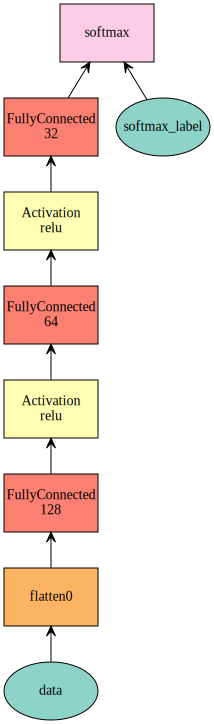

In [20]:
mx.viz.plot_network(symbol=mlp)

# Train the MLP Model

In [21]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

mlp_model = mx.mod.Module(symbol=mlp, context=contexts)
mlp_model.fit(train_iter,
              eval_data=val_iter,
              optimizer='sgd', 
              optimizer_params={'learning_rate':0.01,'momentum': 0.9},
              eval_metric='acc',
              num_epoch=num_epochs)

INFO:root:Epoch[0] Train-accuracy=0.021875
INFO:root:Epoch[0] Time cost=0.048
INFO:root:Epoch[0] Validation-accuracy=0.007576
INFO:root:Epoch[1] Train-accuracy=0.021875
INFO:root:Epoch[1] Time cost=2.735
INFO:root:Epoch[1] Validation-accuracy=0.010859
INFO:root:Epoch[2] Train-accuracy=0.031250
INFO:root:Epoch[2] Time cost=2.729
INFO:root:Epoch[2] Validation-accuracy=0.008586
INFO:root:Epoch[3] Train-accuracy=0.037500
INFO:root:Epoch[3] Time cost=2.735
INFO:root:Epoch[3] Validation-accuracy=0.007828
INFO:root:Epoch[4] Train-accuracy=0.034375
INFO:root:Epoch[4] Time cost=2.727
INFO:root:Epoch[4] Validation-accuracy=0.009343
INFO:root:Epoch[5] Train-accuracy=0.043750
INFO:root:Epoch[5] Time cost=2.727
INFO:root:Epoch[5] Validation-accuracy=0.007071
INFO:root:Epoch[6] Train-accuracy=0.046875
INFO:root:Epoch[6] Time cost=2.730
INFO:root:Epoch[6] Validation-accuracy=0.007071
INFO:root:Epoch[7] Train-accuracy=0.031250
INFO:root:Epoch[7] Time cost=2.733
INFO:root:Epoch[7] Validation-accuracy=0

# Test Accuracy of the MLP Model for top 3 predictions

### Lets take the mean of the probbilities as the threshold values to choose top 3 labels

In [22]:
prob = mlp_model.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob.asnumpy(),3,threshold=prob.asnumpy().mean())
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.022222222222222223

### Lets save the MLP Model

In [23]:
mlp_model.save_checkpoint("mlp-model",0)

INFO:root:Saved checkpoint to "mlp-model-0000.params"


# Reset the Data Iterators for Train Validation and Test

In [24]:
train_iter.reset()
val_iter.reset()
test_iter.reset()

# Define the CNN Model

In [25]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))

flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="relu")

fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=num_classes)

cnn = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

# Lets Visualize the CNN Model

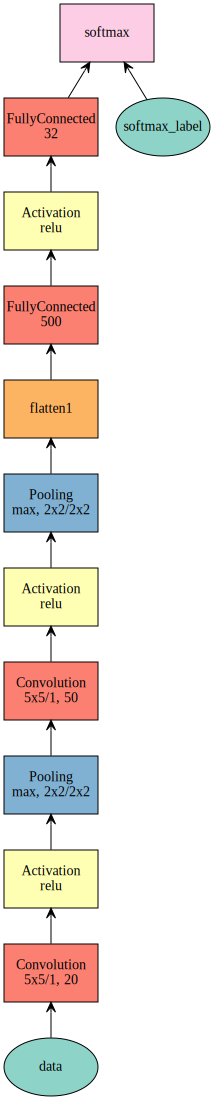

In [26]:
mx.viz.plot_network(symbol=cnn)

# Train the CNN Model

In [27]:
# create a trainable module on GPU 0
cnn_model = mx.mod.Module(symbol=cnn, context=contexts)
# train with the same
cnn_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01,'momentum':0.9},
                eval_metric='acc',
                num_epoch=num_epochs)

INFO:root:Epoch[0] Train-accuracy=0.028125
INFO:root:Epoch[0] Time cost=3.450
INFO:root:Epoch[0] Validation-accuracy=0.010354
INFO:root:Epoch[1] Train-accuracy=0.050000
INFO:root:Epoch[1] Time cost=2.731
INFO:root:Epoch[1] Validation-accuracy=0.007828
INFO:root:Epoch[2] Train-accuracy=0.025000
INFO:root:Epoch[2] Time cost=2.735
INFO:root:Epoch[2] Validation-accuracy=0.007323
INFO:root:Epoch[3] Train-accuracy=0.034375
INFO:root:Epoch[3] Time cost=2.733
INFO:root:Epoch[3] Validation-accuracy=0.007576
INFO:root:Epoch[4] Train-accuracy=0.025000
INFO:root:Epoch[4] Time cost=2.741
INFO:root:Epoch[4] Validation-accuracy=0.009596
INFO:root:Epoch[5] Train-accuracy=0.028125
INFO:root:Epoch[5] Time cost=2.720
INFO:root:Epoch[5] Validation-accuracy=0.006566
INFO:root:Epoch[6] Train-accuracy=0.031250
INFO:root:Epoch[6] Time cost=2.723
INFO:root:Epoch[6] Validation-accuracy=0.006818
INFO:root:Epoch[7] Train-accuracy=0.028125
INFO:root:Epoch[7] Time cost=2.744
INFO:root:Epoch[7] Validation-accuracy=0

# Test Accuracy of CNN

In [28]:
prob = cnn_model.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob.asnumpy(),3,threshold=prob.asnumpy().mean())
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.021212121212121213

# Lets save the CNN Model

In [29]:
cnn_model.save_checkpoint("cnn-model",0)

INFO:root:Saved checkpoint to "cnn-model-0000.params"


# Lets see how to use PreTrained Model using GLUON

### Get pretrained resnet

In [30]:
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

net = models.resnet101_v1(pretrained=True, prefix='logo')

### Lets modify the last layer and initialize the weights using the pretrained weights

In [31]:
mod_resnet_gluon = models.resnet101_v1(prefix='logo', classes=num_classes)
mod_resnet_gluon.collect_params().initialize()
mod_resnet_gluon.features = net.features
print(mod_resnet_gluon)

ResNetV1(
  (classifier): HybridSequential(
    (0): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
    (1): Dense(2048 -> 32, linear)
  )
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BottleneckV1(
        (body): HybridSequential(
          (0): Conv2D(64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
          (5): Activation(relu)
          (6): Conv2D(256, kernel_size=(1, 1), stride=(1, 1))
          (7): Batc

### Lets define the evaliation function

In [32]:
def evaluate(net, data_iter, ctx):
    data_iter.reset()
    acc = mx.metric.Accuracy()
    for batch in data_iter:
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        acc.update(label, outputs)
    return acc.get()[1]

### Lets define the function for training

In [33]:
def train(net, train_iter, val_iter, epochs, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02, 'momentum': 0.9})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    best_accuracy = 0
    best_epoch = 0
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        for i, batch in enumerate(train_iter):
            # the model zoo models expect normalized images
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            outputs = []
            Ls = []
            with autograd.record():
                for x, y in zip(data, label):
                    z = net(x)
                    L = loss(z, y)
                    Ls.append(L)
                    outputs.append(z)
                for L in Ls:
                    L.backward()
            trainer.step(batch.data[0].shape[0])
            
        val_accuracy = evaluate(net, val_iter, ctx)
        train_accuracy = evaluate(net, train_iter, ctx)

        logging.info('Epoch[%d] training accuracy: %s'%(epoch, train_accuracy))
        logging.info('Epoch[%d] validation accuracy: %s'%(epoch, val_accuracy))
        logging.info('Epoch[%d] time cost: %f'%(epoch, time.time()-tic))
                     

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch
            logging.info('Best validation accuracy found. Checkpointing...')
            net.save_params('resnet-gluon.params')

mod_resnet_gluon.hybridize()
if num_epochs > 0:
    mod_resnet_gluon.collect_params().reset_ctx(contexts)
    train(mod_resnet_gluon, train_iter, val_iter, num_epochs, contexts)

INFO:root:Epoch[0] training accuracy: 0.025
INFO:root:Epoch[0] validation accuracy: 0.00909090909091
INFO:root:Epoch[0] time cost: 50.401864
INFO:root:Best validation accuracy found. Checkpointing...
INFO:root:Epoch[1] training accuracy: 0.03125
INFO:root:Epoch[1] validation accuracy: 0.00757575757576
INFO:root:Epoch[1] time cost: 50.042963
INFO:root:Epoch[2] training accuracy: 0.03125
INFO:root:Epoch[2] validation accuracy: 0.00757575757576
INFO:root:Epoch[2] time cost: 49.336888
INFO:root:Epoch[3] training accuracy: 0.028125
INFO:root:Epoch[3] validation accuracy: 0.00858585858586
INFO:root:Epoch[3] time cost: 49.104645
INFO:root:Epoch[4] training accuracy: 0.0625
INFO:root:Epoch[4] validation accuracy: 0.0113636363636
INFO:root:Epoch[4] time cost: 48.947668
INFO:root:Best validation accuracy found. Checkpointing...
INFO:root:Epoch[5] training accuracy: 0.059375
INFO:root:Epoch[5] validation accuracy: 0.00909090909091
INFO:root:Epoch[5] time cost: 49.689168
INFO:root:Epoch[6] trainin

### Define the function for predicting test batch

In [34]:
def predict_batch(data_iter, ctx, net):
    flag = True
    prob = None
    for batch in data_iter:
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        for x in data:
            pred = net(x)
            if flag:
                prob = pred.asnumpy()
                flag = False
            else:
                prob = np.append(prob,pred.asnumpy(),axis=0)    
    return prob

### Accuracy of the Model

In [36]:
test_iter.reset()
prob = predict_batch(test_iter,contexts,mod_resnet_gluon)
top_3_prediction = get_top_n_label_index_prediction(prob,3,threshold=prob.mean())
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.033585858585858587

# Lets see how to use PreTrained Model using SYM

### Function for downloading a Pretrained Model 

In [37]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

### Function for fine tuning the Pretrained model based on the number of classes for a specific use case

In [38]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

### Function for fitting the fine tuned Model

In [39]:
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

def fit(symbol, arg_params, aux_params, train, val, contexts,num_epochs):
    mod = mx.mod.Module(symbol=symbol, context=contexts)
    mod.fit(train, val,
        num_epoch=num_epochs,
        arg_params=arg_params,
        aux_params=aux_params,
        allow_missing=True,
        kvstore='device',
        optimizer='sgd',
        optimizer_params={'learning_rate':0.01,'momentum':0.9},
        initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2),
        eval_metric='acc')
    metric = mx.metric.Accuracy()
    return mod,mod.score(val, metric)

### Fit the Pretrained SYM Model

In [40]:
train_iter.reset()
val_iter.reset()
test_iter.reset()

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes)

mod_resnet,mod_score = fit(new_sym, new_args, aux_params, train_iter, val_iter, contexts,num_epochs=num_epochs)


INFO:root:Epoch[0] Train-accuracy=0.021875
INFO:root:Epoch[0] Time cost=1.302
INFO:root:Epoch[0] Validation-accuracy=0.008586
INFO:root:Epoch[1] Train-accuracy=0.065625
INFO:root:Epoch[1] Time cost=2.796
INFO:root:Epoch[1] Validation-accuracy=0.010354
INFO:root:Epoch[2] Train-accuracy=0.043750
INFO:root:Epoch[2] Time cost=2.915
INFO:root:Epoch[2] Validation-accuracy=0.006313
INFO:root:Epoch[3] Train-accuracy=0.059375
INFO:root:Epoch[3] Time cost=2.916
INFO:root:Epoch[3] Validation-accuracy=0.011111
INFO:root:Epoch[4] Train-accuracy=0.068750
INFO:root:Epoch[4] Time cost=3.003
INFO:root:Epoch[4] Validation-accuracy=0.017677
INFO:root:Epoch[5] Train-accuracy=0.084375
INFO:root:Epoch[5] Time cost=3.012
INFO:root:Epoch[5] Validation-accuracy=0.017424
INFO:root:Epoch[6] Train-accuracy=0.134375
INFO:root:Epoch[6] Time cost=2.814
INFO:root:Epoch[6] Validation-accuracy=0.019444
INFO:root:Epoch[7] Train-accuracy=0.137500
INFO:root:Epoch[7] Time cost=2.859
INFO:root:Epoch[7] Validation-accuracy=0

### Test Accuracy of the Pretrained Model

In [41]:
prob = mod_resnet.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob.asnumpy(),3,threshold=0.5)
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.7583333333333333

### Lets save the Model

In [42]:
mod_resnet.save_checkpoint("resnet-model",0)

INFO:root:Saved checkpoint to "resnet-model-0000.params"


# Lets define functions to predict an online image and load already trained model for prediction

In [43]:
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    return fname

def preprocess_image_sym(fname):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (64, 64))
    plt.imshow(img)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    
    return img

def preprocess_image_gluon(fname):
    img = io.imread(fname)
    img = cv2.resize(img, (64, 64))
    plt.imshow(img)


    if img.shape[2] == 4:
        img = rgba2rgb(img)
    image = mx.nd.array(img).astype(np.uint8)
    image = mx.image.resize_short(image, 256)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0).as_in_context(contexts[0])
    return image

def predict_gluon(net, url):
    fname = get_image(url)
    img = preprocess_image_gluon(fname)
    out = mx.nd.SoftmaxActivation(net(img))
    prob = out[0].asnumpy()
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], index_to_label([a[i]])))

def predict_sym(mod,url):
    fname = get_image(url)
    img = preprocess_image_sym(fname)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], index_to_label([a[i]])))
        
def load_sym_model(pathname):
    sym, arg_params, aux_params = mx.model.load_checkpoint(pathname, 0)
    mod = mx.mod.Module(symbol=sym, context=contexts, label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,64,64))], 
             label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    return mod

def load_gluon_model(mod,pathname):
    mod.load_params(pathname, mx.gpu())
    return mod

# Lets load the stored Models

In [44]:
mod_mlp = load_sym_model('mlp-model')
mod_cnn = load_sym_model('cnn-model')
mod_res_sym = load_sym_model('resnet-model')
mod_res_gluon = load_gluon_model(mod_resnet_gluon,'resnet-gluon.params')

# Lets apply different models and see the output

In [45]:
image_url = 'https://i.pinimg.com/736x/30/7a/b3/307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg'

### Use MLP

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): i.pinimg.com
DEBUG:urllib3.connectionpool:https://i.pinimg.com:443 "GET /736x/30/7a/b3/307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg HTTP/1.1" 200 51268
INFO:root:downloaded https://i.pinimg.com/736x/30/7a/b3/307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg into 307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg successfully


probability=0.031713, class=['erdinger']
probability=0.031666, class=['HP']
probability=0.031644, class=['stellaartois']
probability=0.031580, class=['guiness']
probability=0.031576, class=['ferrari']


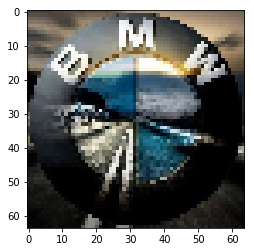

In [46]:
predict_sym(mod_mlp,image_url)

### Use CNN

INFO:root:307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg exists, skipping download


probability=0.031714, class=['texaco']
probability=0.031605, class=['apple']
probability=0.031541, class=['ups']
probability=0.031539, class=['heineken']
probability=0.031499, class=['singha']


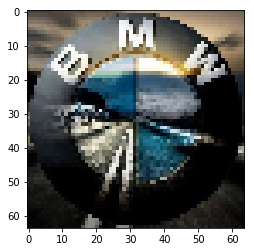

In [47]:
predict_sym(mod_cnn,image_url)

### Use PRETRAINED MODEL

### SYM Model

INFO:root:307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg exists, skipping download


probability=0.173611, class=['starbucks']
probability=0.122301, class=['nvidia']
probability=0.120549, class=['adidas']
probability=0.076641, class=['fosters']
probability=0.065346, class=['ups']


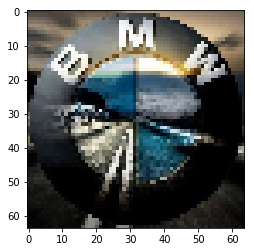

In [48]:
predict_sym(mod_res_sym,image_url)

### GLUON Model

INFO:root:307ab308010b03eb53696a168a0afc5a--bmw-motorad-bmw-z.jpg exists, skipping download


probability=1.000000, class=['adidas']
probability=0.000000, class=['HP']
probability=0.000000, class=['texaco']
probability=0.000000, class=['ups']
probability=0.000000, class=['tsingtao']


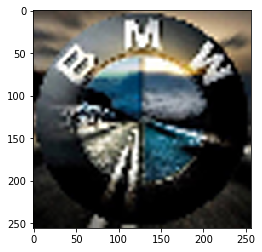

In [49]:
predict_gluon(mod_resnet_gluon,image_url)